# PREDICT DIFFERENCE IN REALISED VOLATILITY

## 0. Setup and Configuration

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import random
import joblib

# Ensure we can import from the src folder
sys.path.append(os.path.abspath('..'))

import importlib
import src.data as data
import src.lstm as lstm
from utils.metrics import evaluate_diff_model

importlib.reload(data)
importlib.reload(lstm)


# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# --- Global Configuration ---
TICKER = "TSLA"
START_DATE = "2015-01-01"
SEQ_LEN = 30
BATCH_SIZE = 32
FEATURE_COLS = [
    "LogReturn", "RealisedVolatility", "RSI_14",
    "BB_Width", "MACD", "YZVolatility", "Log_CO", "Log_HL",
]

In [2]:
print("Loading and computing features...")
df = data.download_data(TICKER, start_date=START_DATE)
df = data.compute_features(df)

# Create Difference Target: Diff_t = RV_t - RV_{t-1}
df["RV_Diff"] = df["RealisedVolatility"].diff()
df = df.dropna()

# --- Scaling (Fit on Train Only) ---
train_size_pct = 0.7
train_split_idx = int(len(df) * train_size_pct)

scaler = StandardScaler()
scaler.fit(df[FEATURE_COLS].iloc[:train_split_idx])
df.loc[:, FEATURE_COLS] = scaler.transform(df[FEATURE_COLS])

# --- Sequence Creation ---
# 1. Scaled Features & Difference Target (For Training)
X, y_diff, dates = data.create_sequences(df, FEATURE_COLS, target_col="RV_Diff", seq_len=SEQ_LEN)

# 2. Unscaled Raw Target (For Reconstruction/Evaluation later)
# We re-run create_sequences on the raw dataframe to align indices perfectly
_, y_raw, _ = data.create_sequences(df, FEATURE_COLS, target_col="RealisedVolatility", seq_len=SEQ_LEN)
# --- Train/Val/Test Split ---
test_size_pct = 0.15
n_samples = len(X)
train_end = int(n_samples * train_size_pct)
test_start = int(n_samples * (1 - test_size_pct))

# Training Sets
X_train = X[:train_end]
y_train_diff = y_diff[:train_end]

# Validation Sets
X_val = X[train_end:test_start]
y_val_diff = y_diff[train_end:test_start]

# Test Sets
X_test = X[test_start:]
y_test_diff = y_diff[test_start:]
dates_test = dates[test_start:]

# Flattened inputs for Random Forest: (N, Seq_Len, Features) -> (N, Seq_Len * Features)
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

# Loaders for LSTM
train_loader = DataLoader(lstm.LSTMDataset(X_train, y_train_diff), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(lstm.LSTMDataset(X_val, y_val_diff), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(lstm.LSTMDataset(X_test, y_test_diff), batch_size=BATCH_SIZE, shuffle=False)

# --- Reconstruction Targets for Test Set ---
# y_raw[i] is RV at time t. 
# For the test set starting at `test_start`, the "previous" value is at `test_start - 1`
y_test_prev_raw = y_raw[test_start-1 : -1]  # The anchor for reconstruction
y_test_actual_raw = y_raw[test_start:]      # The ground truth

print(f"Data processed. Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Loading and computing features...


[*********************100%***********************]  1 of 1 completed

Data processed. Train samples: 1899, Test samples: 407


## 1. Models

### 1.1 Random Forest

Training Random Forest...
--- Random Forest Performance ---
MAE:  0.089648
RMSE: 0.189665


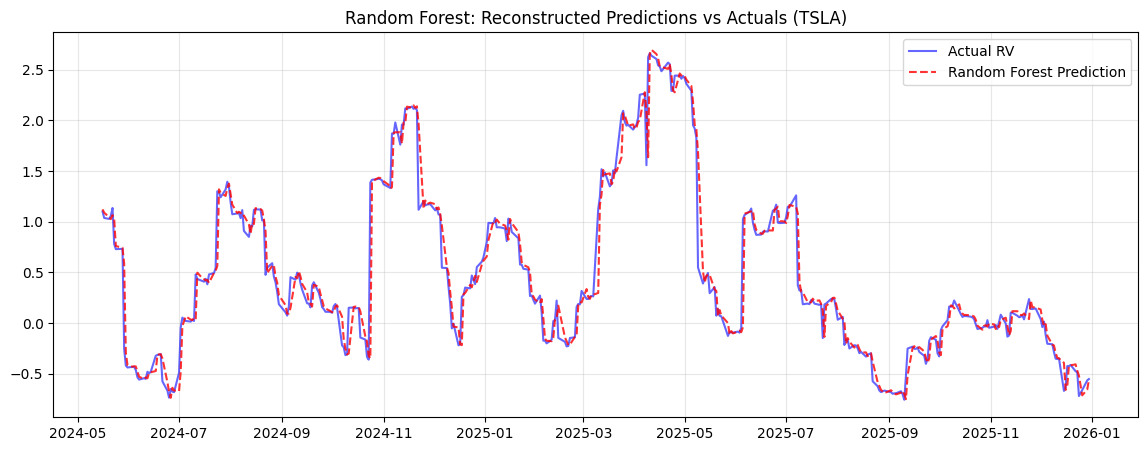

['../models/TSLA_diff_rf.joblib']

In [12]:
# 1. Initialize and Train
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
print("Training Random Forest...")
rf_model.fit(X_train_flatten, y_train_diff)

# 2. Predict Differences
rf_preds_diff = rf_model.predict(X_test_flatten)

# 3. Evaluate
rf_mae, rf_rmse, rf_preds_final = evaluate_diff_model(
    rf_preds_diff, y_test_prev_raw, y_test_actual_raw, "Random Forest", dates_test, TICKER
)

joblib.dump(rf_model, f"../models/{TICKER}_diff_rf.joblib")

### 1.2 LSTM

Training LSTM...
Epoch 10/50 | Train RMSE: 0.039225 | Val RMSE: 0.036644
Early stopping at epoch 15. Best Val RMSE: 0.035704, at epoch 5.

Training finished. Best model saved to ../models/TSLA_diff_lstm.pth 
Best Val RMSE: 0.035704 at epoch 5

--- LSTM Performance ---
MAE:  0.098224
RMSE: 0.205327


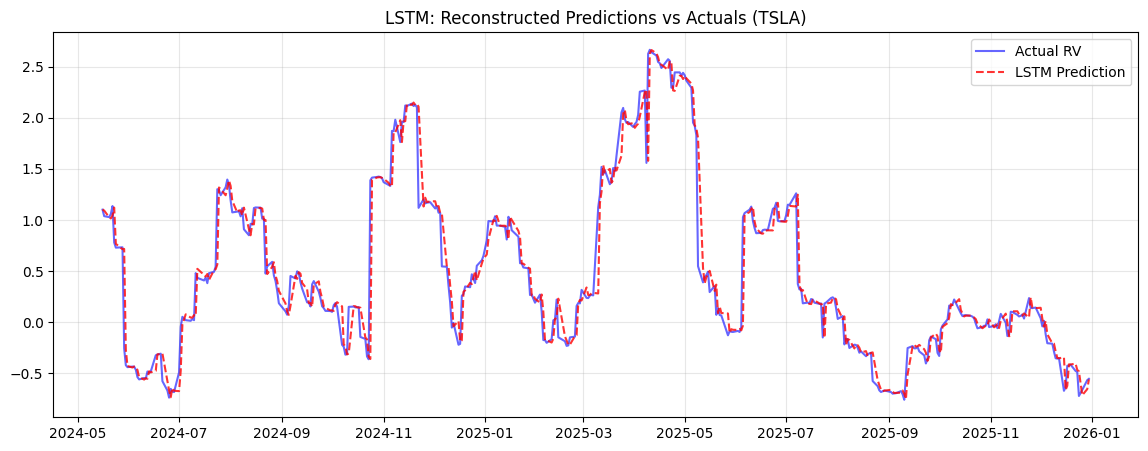

In [13]:
# 1. Initialize and Train
lstm_model = lstm.LSTMRegressor(
    input_size=len(FEATURE_COLS),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
print("Training LSTM...")
train_lstm_hist = lstm.train_lstm(
    lstm_model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=0.001,
    patience=10,
    model_name=f"{TICKER}_diff_lstm.pth"
)

# 2. Predict Differences
lstm_model.eval()
lstm_preds_diff = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        out = lstm_model(X_batch)
        lstm_preds_diff.extend(out.squeeze().numpy())
lstm_preds_diff = np.array(lstm_preds_diff)

# 3. Evaluate
lstm_mae, lstm_rmse, lstm_preds_final = evaluate_diff_model(
    lstm_preds_diff, y_test_prev_raw, y_test_actual_raw, "LSTM", dates_test
)

### 1.3 Attention LSTM

Training Attention LSTM...
Epoch 10/50 | Train RMSE: 0.039780 | Val RMSE: 0.036596
Early stopping at epoch 16. Best Val RMSE: 0.036483, at epoch 6.

Training finished. Best model saved to ../models/TSLA_diff_lstm_attention.pth 
Best Val RMSE: 0.036483 at epoch 6

--- Attention LSTM Performance ---
MAE:  0.098631
RMSE: 0.206867


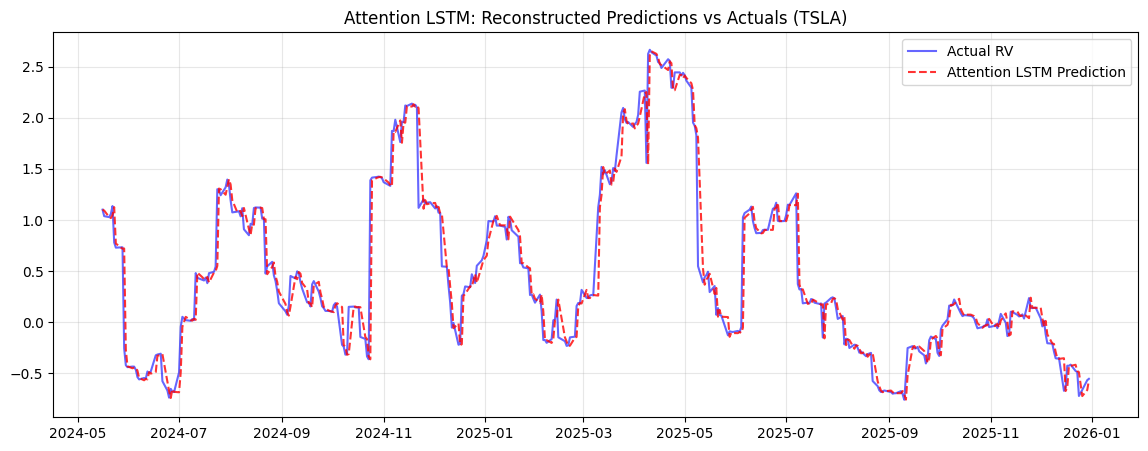

In [14]:
# 1. Initialize and Train
lstm_attention_model = lstm.LSTMAttentionRegressor(
    input_size=len(FEATURE_COLS),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
print("Training Attention LSTM...")
train_lstm_attention_hist = lstm.train_lstm(
    lstm_attention_model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=0.001,
    patience=10,
    model_name=f"{TICKER}_diff_lstm_attention.pth"
)

# 2. Predict Differences
lstm_attention_model.eval()
lstm_attention_preds_diff = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        out = lstm_attention_model(X_batch)
        lstm_attention_preds_diff.extend(out.squeeze().numpy())
lstm_attention_preds_diff = np.array(lstm_attention_preds_diff)

# 3. Evaluate
lstm_attention_mae, lstm_attention_rmse, lstm_attention_preds_final = evaluate_diff_model(
    lstm_attention_preds_diff, y_test_prev_raw, y_test_actual_raw, "Attention LSTM", dates_test
)

## 2. Results

In [15]:
# Naive Baseline: Predict Zero Change
from sklearn.metrics import mean_absolute_error, mean_squared_error
naive_mae = mean_absolute_error(y_test_actual_raw, y_test_prev_raw)
naive_rmse = np.sqrt(mean_squared_error(y_test_actual_raw, y_test_prev_raw))
print(f"Naive Baseline - MAE: {naive_mae}, RMSE: {naive_rmse}")

Naive Baseline - MAE: 0.09898213297128677, RMSE: 0.2077785894504997


In [16]:
results_df = pd.DataFrame({
    'MAE': [naive_mae, rf_mae, lstm_mae, lstm_attention_mae],
    'RMSE': [naive_rmse, rf_rmse, lstm_rmse, lstm_attention_rmse],
    'Improvement over Naive (%)': [
        0.0,
        (naive_mae - rf_mae) / naive_mae * 100,
        (naive_mae - lstm_mae) / naive_mae * 100,
        (naive_mae - lstm_attention_mae) / naive_mae * 100
    ]
}, index=['Naive Baseline', 'Random Forest', 'LSTM', 'LSTM with Attention'])

print(results_df)

                          MAE      RMSE  Improvement over Naive (%)
Naive Baseline       0.098982  0.207779                    0.000000
Random Forest        0.089648  0.189665                    9.430006
LSTM                 0.098224  0.205327                    0.765471
LSTM with Attention  0.098631  0.206867                    0.355224


## 2. XAI

In [17]:
# Load models
rf_model = joblib.load(f"../models/{TICKER}_diff_rf.joblib")
lstm_model = lstm.LSTMRegressor(
    input_size=len(FEATURE_COLS),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
lstm_model.load_state_dict(torch.load(f"../models/{TICKER}_diff_lstm.pth"))
lstm_model.eval()
lstm_attention_model = lstm.LSTMAttentionRegressor(
    input_size=len(FEATURE_COLS),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
lstm_attention_model.load_state_dict(torch.load(f"../models/{TICKER}_diff_lstm_attention.pth"))
lstm_attention_model.eval()

LSTMAttentionRegressor(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.3)
  (attention): Attention(
    (attn): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

### A) SHAP

#### 1. Random Forest Regressor

/tmp/ipykernel_10155/4232413759.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_selected, X_shap_selected, show=True)


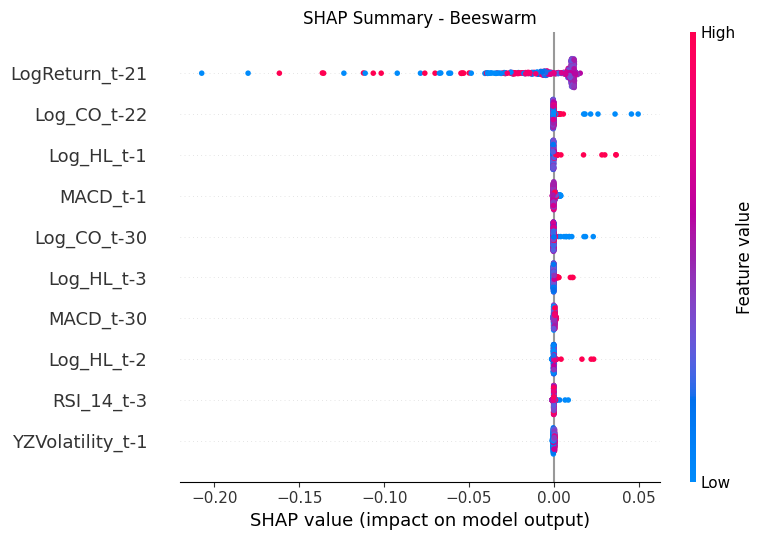

/tmp/ipykernel_10155/4232413759.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_selected, X_shap_selected, plot_type="bar", show=True)


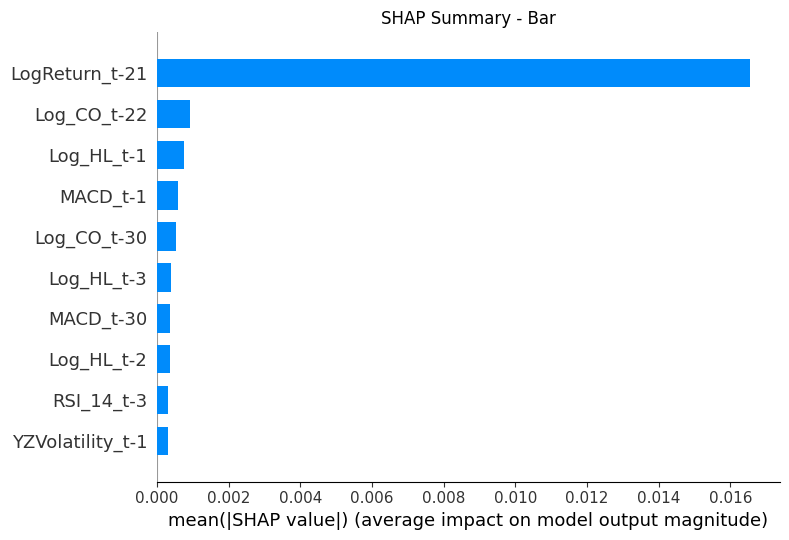

In [18]:
import shap


def plot_shap_summary(model, X_data, feature_cols):
    """
    Plots SHAP summary (flattened data).
    Args:
        model: Trained model (e.g., RandomForestRegressor)
        X_data: Input data (N, seq_len * num_features)
    """
    # 1. Generate Feature Names: [Day1_Feat1, Day1_Feat2, ..., Day30_Feat1...]
    seq_len = X_data.shape[1] // len(feature_cols)
    flat_feature_names = []
    for t in range(seq_len):
        for col in feature_cols:
             flat_feature_names.append(f"{col}_t-{seq_len - t}")

    X_data_df = pd.DataFrame(X_data, columns=flat_feature_names)
    X_shap = X_data_df.sample(n=min(500, len(X_data_df)), random_state=SEED)

    # 2. Calculate SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)
    
    # Select top 10 features by mean absolute SHAP value
    most_important_indices = np.argsort(-np.abs(shap_values).mean(0))[:10]
    X_shap_selected = X_shap.iloc[:, most_important_indices]
    shap_values_selected = shap_values[:, most_important_indices]
    
    # 3. Plot in two subplots
    plt.figure(figsize=(10, 6))
    plt.title(f"SHAP Summary - Beeswarm")
    shap.summary_plot(shap_values_selected, X_shap_selected, show=True)

    plt.figure(figsize=(10, 6))
    plt.title(f"SHAP Summary - Bar")
    shap.summary_plot(shap_values_selected, X_shap_selected, plot_type="bar", show=True)


plot_shap_summary(
    rf_model,
    X_test_flatten,
    FEATURE_COLS
)

#### 2. LSTM Regressor

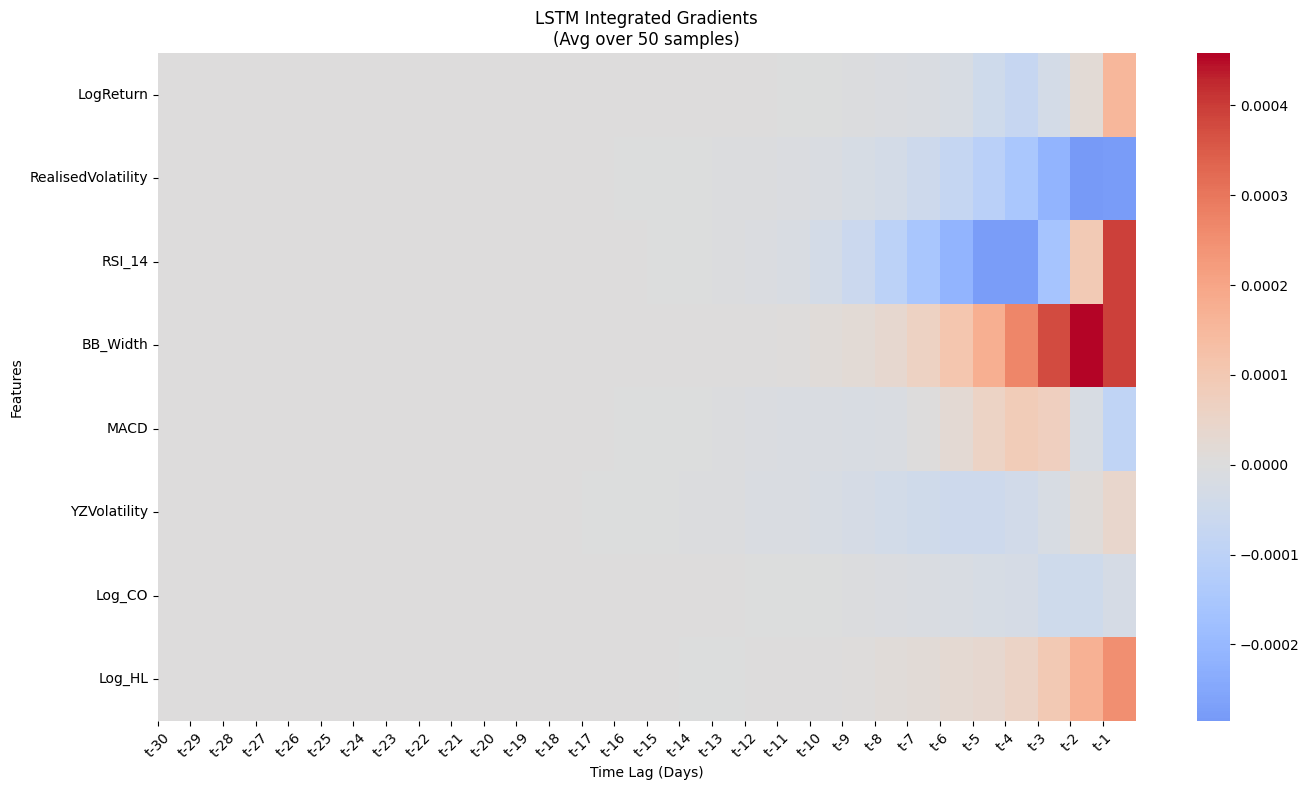

In [ ]:
from captum.attr import IntegratedGradients

def plot_integrated_gradients(model, X_data, feature_names, num_samples=50, title="Feature Importance"):
    """
    Computes and plots Integrated Gradients for an LSTM model.
    
    Args:
        model: The trained PyTorch model.
        X_data: Numpy array of input data (N, Seq_Len, Features).
        feature_names: List of feature names strings.
        num_samples: How many samples to average over (default 50).
        title: Title for the plot.
    """
    model.eval()
    
    # 1. Prepare Data
    # Take a slice of the data
    input_tensor = torch.tensor(X_data[:num_samples], dtype=torch.float32)
    input_tensor.requires_grad = True
    
    # 2. Compute Attributions
    ig = IntegratedGradients(model)
    # attribute() returns a tensor of the same shape as input
    attr, delta = ig.attribute(input_tensor, return_convergence_delta=True)
    
    # 3. Average over samples -> (Seq_Len, Features)
    # We take the absolute value to see magnitude of importance, 
    # or keep raw values to see directional impact (Red=Positive, Blue=Negative).
    # Here we typically keep raw values and average.
    attr_avg = attr.detach().numpy().mean(axis=0)
    
    # 4. Plot
    plt.figure(figsize=(14, 8))
    
    # Transpose so Time is on X-axis, Features on Y-axis
    # attr_avg shape: (30, 8) -> (8, 30)
    ax = sns.heatmap(attr_avg.T, cmap="coolwarm", center=0,
                     yticklabels=feature_names)
    
    ax.set_title(f"{title}\n(Avg over {num_samples} samples)")
    ax.set_xlabel("Time Lag (Days)")
    ax.set_ylabel("Features")
    
    # Fix X-axis labels to show t-30 ... t-1
    seq_len = X_data.shape[1]
    ticks = range(seq_len)
    labels = [f"t-{seq_len - i}" for i in ticks]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    
    plt.tight_layout()
    plt.show()


plot_integrated_gradients(lstm_model, X_test, FEATURE_COLS, title="LSTM Integrated Gradients")

#### 3. Attention LSTM Regressor

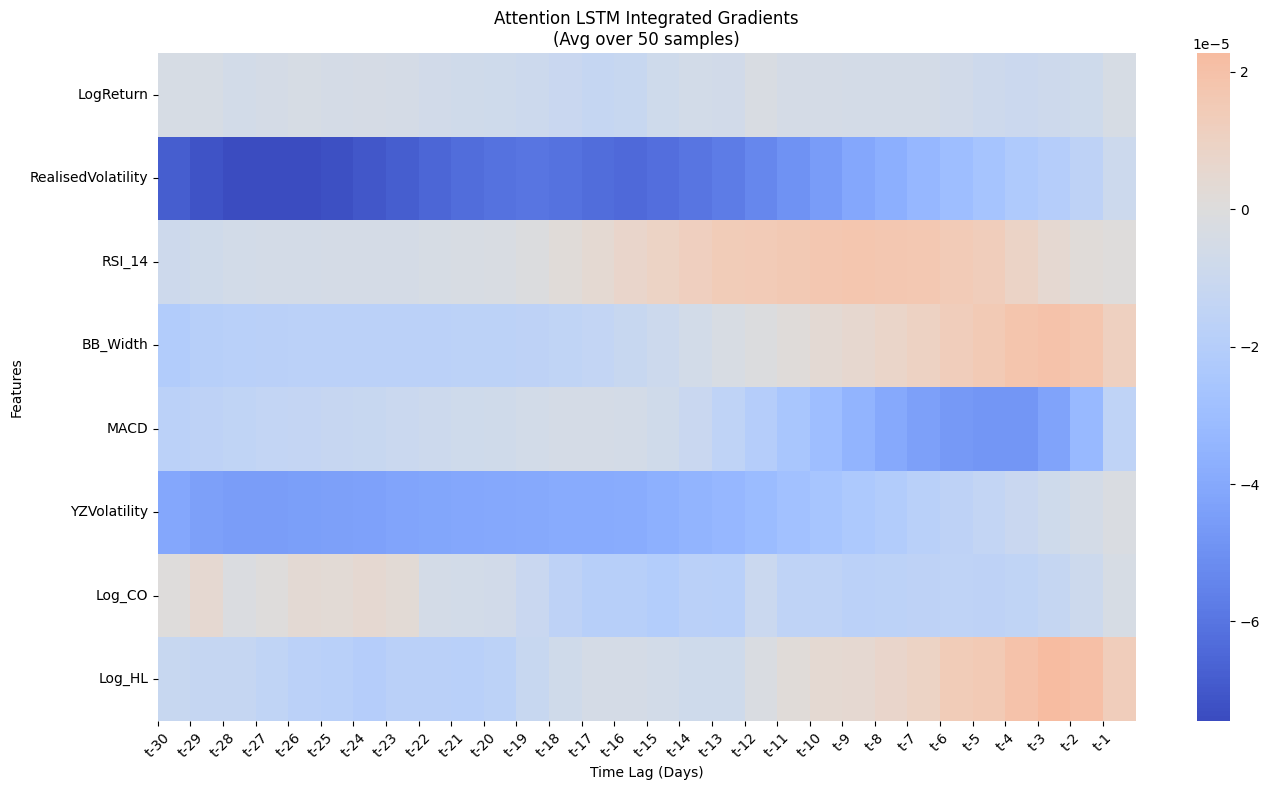

In [20]:
plot_integrated_gradients(lstm_attention_model, X_test, FEATURE_COLS, title="Attention LSTM Integrated Gradients")

## 3. FEATURE SELECTION

In [3]:
SEQ_LEN = 21
FEATURE_COLS_REDUCED = [
    "LogReturn",
    "RealisedVolatility",
    "RSI_14",
    "BB_Width",
    "MACD",
    # "YZVolatility",
    # "Log_CO",
    # "Log_HL",
]
keep_indices = [
    FEATURE_COLS.index(col) for col in FEATURE_COLS_REDUCED
]
X_reduced = X[:, -SEQ_LEN:, keep_indices]

X_train_fs = X_reduced[:train_end]
X_val_fs = X_reduced[train_end:test_start]
X_test_fs = X_reduced[test_start:]

# Flatten inputs for Random Forest: (N, Seq_Len, Features) -> (N, Seq_Len * Features)
X_train_flatten_fs = X_train_fs.reshape(X_train_fs.shape[0], -1)
X_test_flatten_fs = X_test_fs.reshape(X_test_fs.shape[0], -1)

# Loaders for LSTM
train_loader_fs = DataLoader(lstm.LSTMDataset(X_train_fs, y_train_diff), batch_size=BATCH_SIZE, shuffle=True)
val_loader_fs = DataLoader(lstm.LSTMDataset(X_val_fs, y_val_diff), batch_size=BATCH_SIZE, shuffle=False)
test_loader_fs = DataLoader(lstm.LSTMDataset(X_test_fs, y_test_diff), batch_size=BATCH_SIZE, shuffle=False)

Training Attention LSTM...
Epoch 10/50 | Train RMSE: 0.039592 | Val RMSE: 0.036574
Early stopping at epoch 16. Best Val RMSE: 0.036040, at epoch 6.

Training finished. Best model saved to ../models/TSLA_diff_fs_lstm_attention.pth 
Best Val RMSE: 0.036040 at epoch 6

--- Attention LSTM (Feature Selection) Performance ---
MAE:  0.098586
RMSE: 0.205984


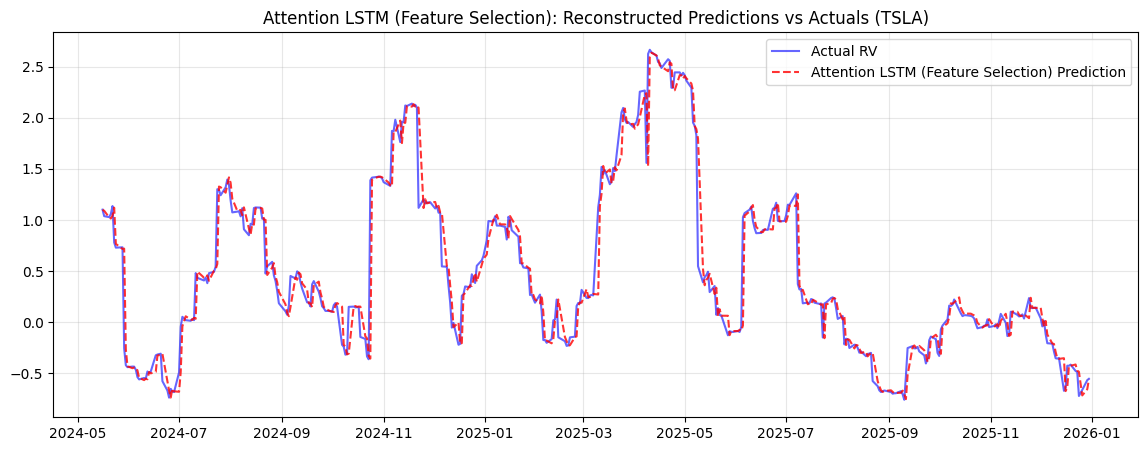

In [22]:
# 1. Initialize and Train
lstm_attention_fs_model = lstm.LSTMAttentionRegressor(
    input_size=len(FEATURE_COLS_REDUCED),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
print("Training Attention LSTM...")
train_lstm_attention_fs_hist = lstm.train_lstm(
    lstm_attention_fs_model,
    train_loader_fs,
    val_loader_fs,
    num_epochs=50,
    lr=0.001,
    patience=10,
    model_name=f"{TICKER}_diff_fs_lstm_attention.pth"
)

# 2. Predict Differences
lstm_attention_fs_model.eval()
lstm_attention_fs_preds_diff = []
with torch.no_grad():
    for X_batch, _ in test_loader_fs:
        out = lstm_attention_fs_model(X_batch)
        lstm_attention_fs_preds_diff.extend(out.squeeze().numpy())
lstm_attention_fs_preds_diff = np.array(lstm_attention_fs_preds_diff)

# 3. Evaluate
lstm_attention_fs_mae, lstm_attention_fs_rmse, lstm_attention_fs_preds_final = evaluate_diff_model(
    lstm_attention_fs_preds_diff, y_test_prev_raw, y_test_actual_raw, "Attention LSTM (Feature Selection)", dates_test
)

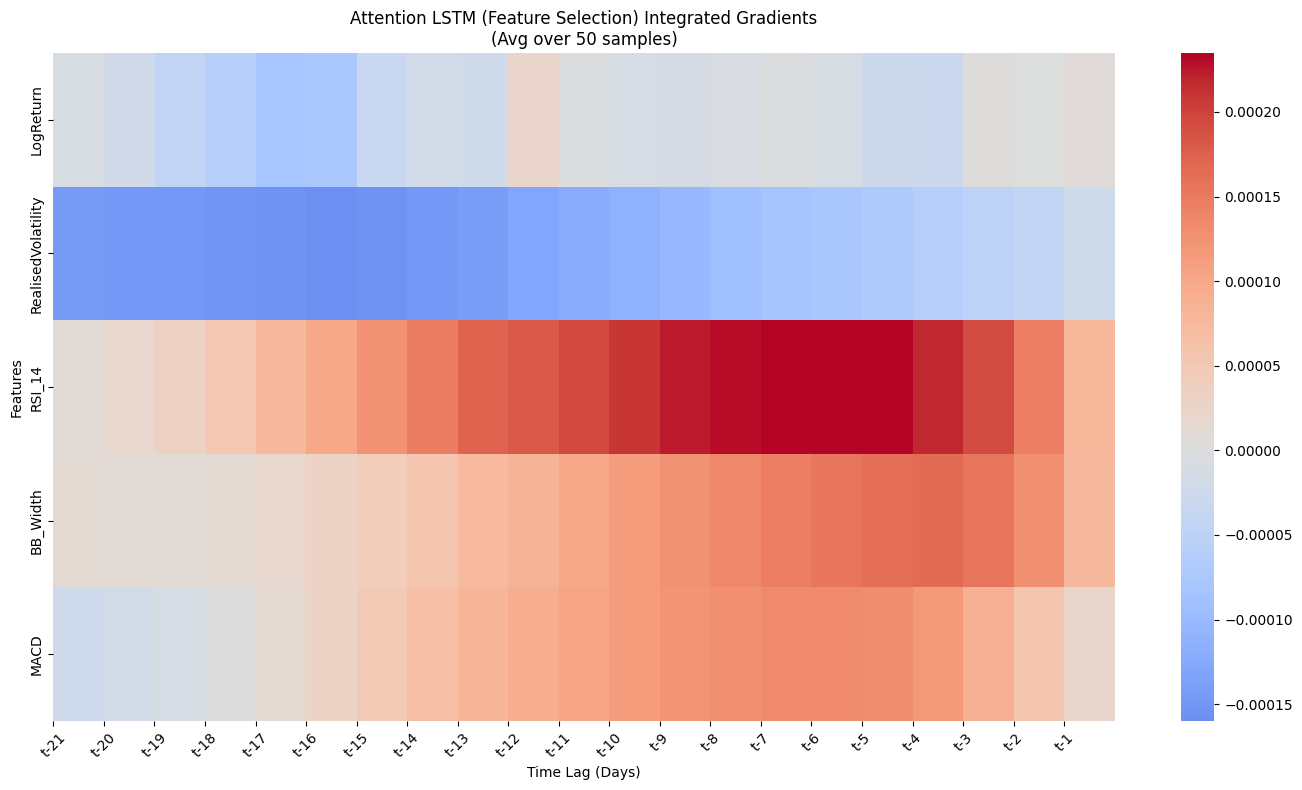

In [23]:
plot_integrated_gradients(lstm_attention_fs_model, X_test_fs, FEATURE_COLS_REDUCED, title="Attention LSTM (Feature Selection) Integrated Gradients")

Training LSTM...
Epoch 10/50 | Train RMSE: 0.039249 | Val RMSE: 0.036117
Early stopping at epoch 15. Best Val RMSE: 0.035908, at epoch 5.

Training finished. Best model saved to ../models/TSLA_diff_fs_lstm.pth 
Best Val RMSE: 0.035908 at epoch 5

--- LSTM (Feature Selection) Performance ---
MAE:  0.098470
RMSE: 0.205227


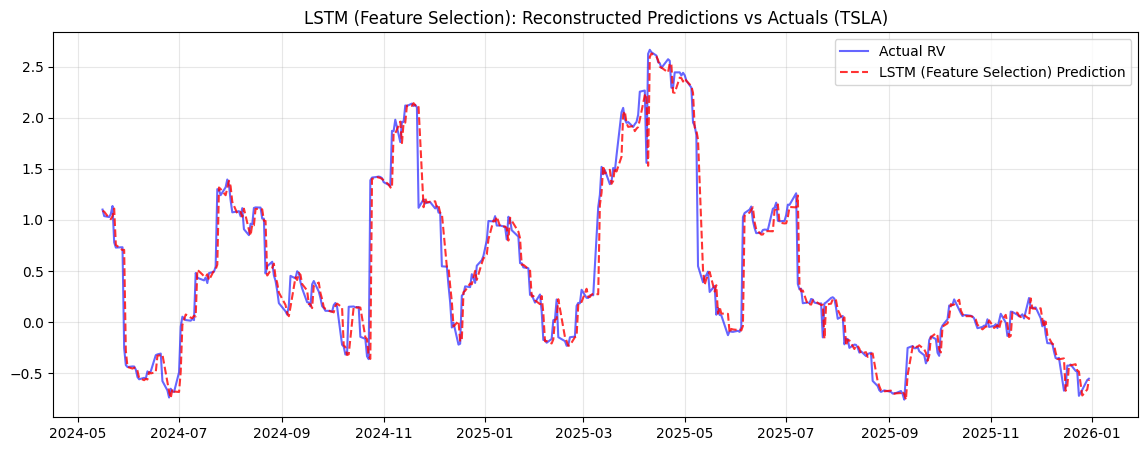

In [24]:
# 1. Initialize and Train
lstm_fs_model = lstm.LSTMRegressor(
    input_size=len(FEATURE_COLS_REDUCED),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
print("Training LSTM...")
train_lstm_hist = lstm.train_lstm(
    lstm_fs_model,
    train_loader_fs,
    val_loader_fs,
    num_epochs=50,
    lr=0.001,
    patience=10,
    model_name=f"{TICKER}_diff_fs_lstm.pth"
)

# 2. Predict Differences
lstm_fs_model.eval()
lstm_fs_preds_diff = []
with torch.no_grad():
    for X_batch, _ in test_loader_fs:
        out = lstm_fs_model(X_batch)
        lstm_fs_preds_diff.extend(out.squeeze().numpy())
lstm_fs_preds_diff = np.array(lstm_fs_preds_diff)

# 3. Evaluate
lstm_fs_mae, lstm_fs_rmse, lstm_fs_preds_final = evaluate_diff_model(
    lstm_fs_preds_diff, y_test_prev_raw, y_test_actual_raw, "LSTM (Feature Selection)", dates_test
)

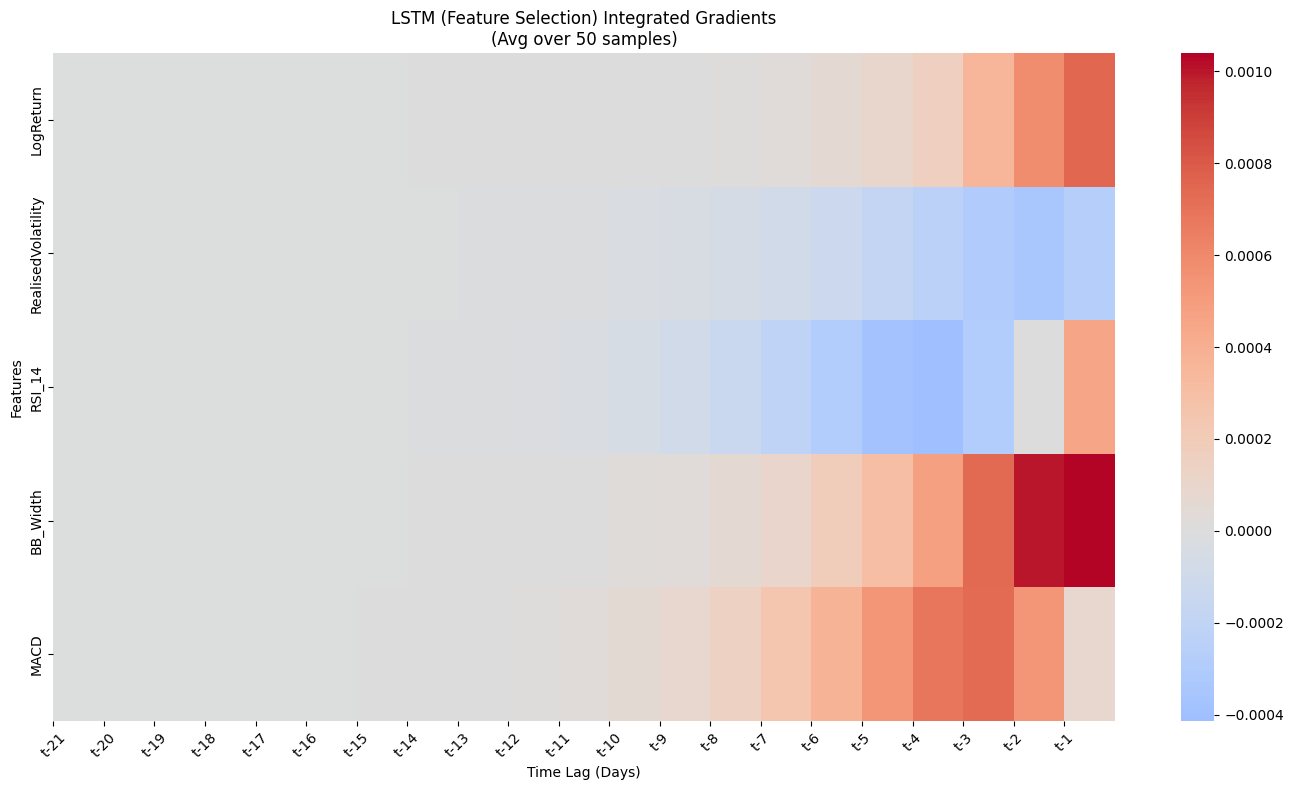

In [25]:
plot_integrated_gradients(lstm_fs_model, X_test_fs, FEATURE_COLS_REDUCED, title="LSTM (Feature Selection) Integrated Gradients")

Training Random Forest...
--- Random Forest Performance ---
MAE:  0.089876
RMSE: 0.189960


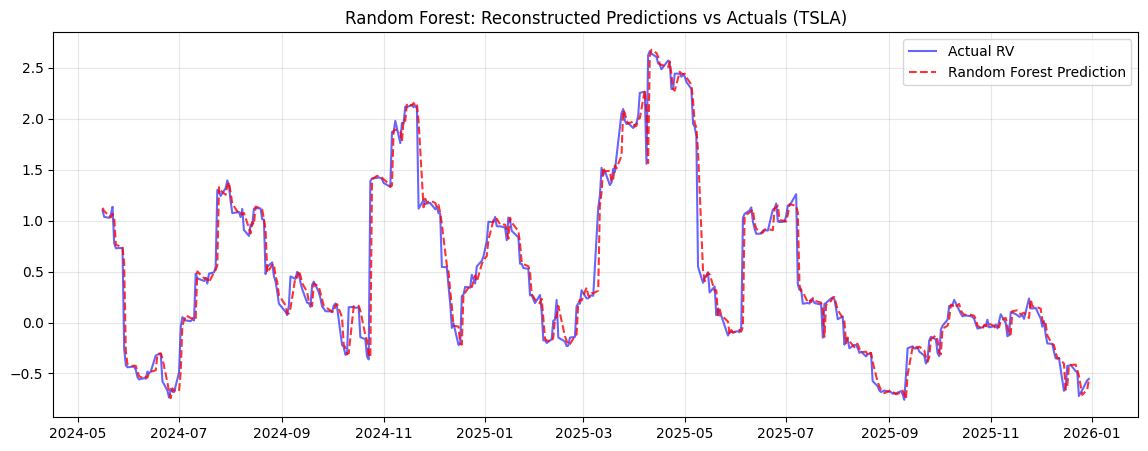

['../models/TSLA_diff_fs_rf.joblib']

In [26]:
# 1. Initialize and Train
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_flatten_fs, y_train_diff)

# 2. Predict Differences
rf_preds_diff = rf_model.predict(X_test_flatten_fs)

# 3. Evaluate using Helper
rf_mae, rf_rmse, rf_preds_final = evaluate_diff_model(
    rf_preds_diff, y_test_prev_raw, y_test_actual_raw, "Random Forest", dates_test
)
joblib.dump(rf_model, f"../models/{TICKER}_diff_fs_rf.joblib")

/tmp/ipykernel_10155/4232413759.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_selected, X_shap_selected, show=True)


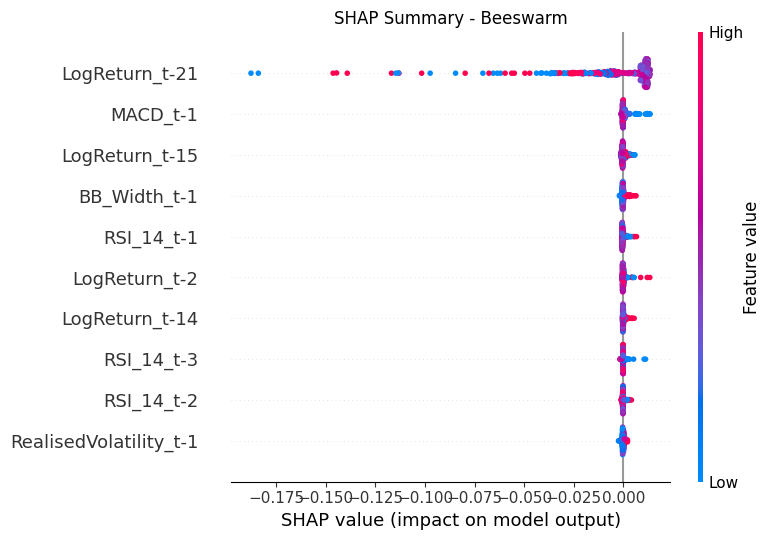

/tmp/ipykernel_10155/4232413759.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_selected, X_shap_selected, plot_type="bar", show=True)


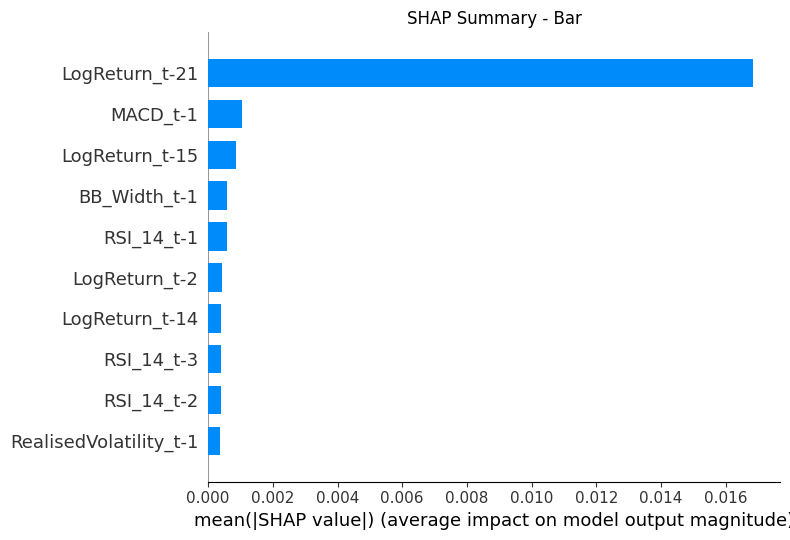

In [27]:
plot_shap_summary(
    rf_model,
    X_test_flatten_fs,
    FEATURE_COLS_REDUCED
)

## 4. MODEL COMPARISON

In [4]:
# Load all models
# 1) Random Forest
rf_model = joblib.load(f"../models/{TICKER}_diff_rf.joblib")
# 2) Random Forest (Feature Selection)
rf_fs_model = joblib.load(f"../models/{TICKER}_diff_fs_rf.joblib")
# 3) LSTM
lstm_model = lstm.LSTMRegressor(
    input_size=len(FEATURE_COLS),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
lstm_model.load_state_dict(torch.load(f"../models/{TICKER}_diff_lstm.pth"))
lstm_model.eval()
# 4) LSTM (Feature Selection)
lstm_fs_model = lstm.LSTMRegressor(
    input_size=len(FEATURE_COLS_REDUCED),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
lstm_fs_model.load_state_dict(torch.load(f"../models/{TICKER}_diff_fs_lstm.pth"))
lstm_fs_model.eval()
# 5) LSTM with Attention
lstm_attention_model = lstm.LSTMAttentionRegressor(
    input_size=len(FEATURE_COLS),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
lstm_attention_model.load_state_dict(torch.load(f"../models/{TICKER}_diff_lstm_attention.pth"))
lstm_attention_model.eval()
# 6) LSTM with Attention (Feature Selection)
lstm_attention_fs_model = lstm.LSTMAttentionRegressor(
    input_size=len(FEATURE_COLS_REDUCED),
    hidden_size=64,
    num_layers=2,
    dropout=0.3
)
lstm_attention_fs_model.load_state_dict(torch.load(f"../models/{TICKER}_diff_fs_lstm_attention.pth"))
lstm_attention_fs_model.eval()

print("All models loaded successfully.")

All models loaded successfully.



Model Performance Summary:
                        MAE    RMSE
Model                              
Naive Baseline       0.0990  0.2078
Random Forest        0.0896  0.1897
Random Forest (FS)   0.0899  0.1900
LSTM                 0.0981  0.2051
LSTM (FS)            0.0980  0.2054
Attention LSTM       0.0988  0.2070
Attention LSTM (FS)  0.0985  0.2065


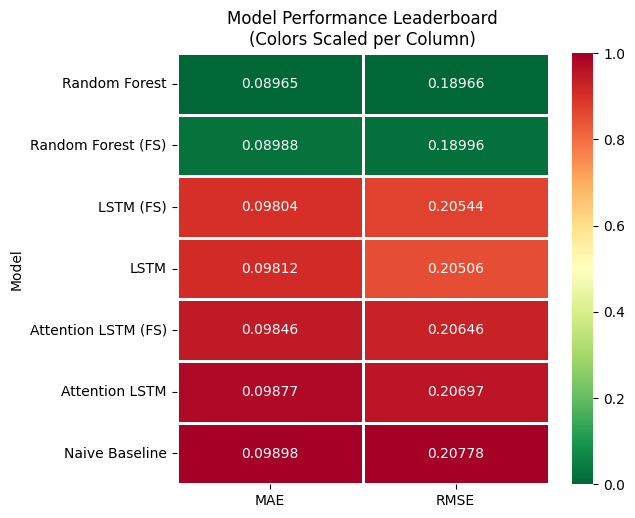

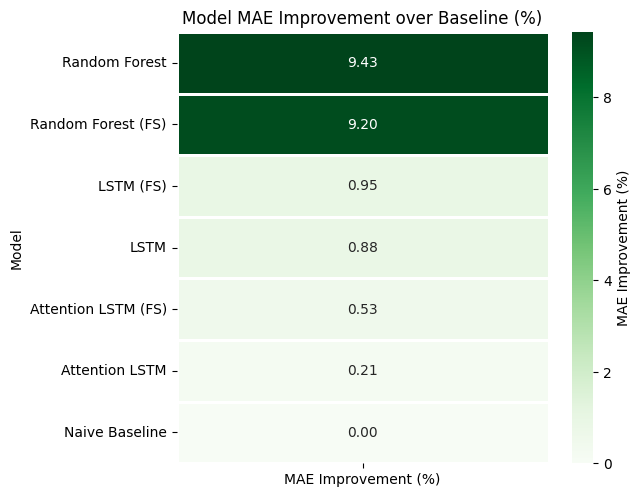

In [7]:
model_metrics = []

def add_metric(name, y_true, y_pred_diff):
    y_reconstructed = y_test_prev_raw + y_pred_diff
    mae = np.mean(np.abs(y_true - y_reconstructed))
    rmse = np.sqrt(np.mean((y_true - y_reconstructed) ** 2))
    model_metrics.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse
    })

# Naive Baseline: Predict Zero Difference
naive_preds_diff = np.zeros_like(y_test_diff)
add_metric("Naive Baseline", y_test_actual_raw, naive_preds_diff)

# Get RF predictions
rf_preds_diff = rf_model.predict(X_test_flatten)
rf_fs_preds_diff = rf_fs_model.predict(X_test_flatten_fs)
add_metric("Random Forest", y_test_actual_raw, rf_preds_diff)
add_metric("Random Forest (FS)", y_test_actual_raw, rf_fs_preds_diff)

# Get LSTM predictions
def predict_lstm_differences(model, loader):
    model.eval()
    preds_diff = []
    with torch.no_grad():
        for X_batch, _ in loader:
            out = model(X_batch)
            preds_diff.extend(out.squeeze().numpy())
    return np.array(preds_diff)
lstm_preds_diff = predict_lstm_differences(lstm_model, test_loader)
lstm_fs_preds_diff = predict_lstm_differences(lstm_fs_model, test_loader_fs)
lstm_attention_preds_diff = predict_lstm_differences(lstm_attention_model, test_loader)
lstm_attention_fs_preds_diff = predict_lstm_differences(lstm_attention_fs_model, test_loader_fs)
add_metric("LSTM", y_test_actual_raw, lstm_preds_diff)
add_metric("LSTM (FS)", y_test_actual_raw, lstm_fs_preds_diff)
add_metric("Attention LSTM", y_test_actual_raw, lstm_attention_preds_diff)
add_metric("Attention LSTM (FS)", y_test_actual_raw, lstm_attention_fs_preds_diff)

# Display Summary Table with 4 decimal places
pd.set_option('display.precision', 4)
metrics_df = pd.DataFrame(model_metrics).set_index('Model')
print("\nModel Performance Summary:")
print(metrics_df)


# 1. Create a Normalized Dataframe for the Colors
# Formula: (x - min) / (max - min) applied to each column independently
# This forces every column to scale from 0.0 (Best) to 1.0 (Worst)
metrics_df.sort_values(by='MAE', inplace=True)
df_colors = metrics_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 2. Plot
plt.figure(figsize=(6, len(metrics_df) * 0.8)) # Adjust height based on number of models
sns.heatmap(
    data=df_colors,      # <--- The COLORS come from the normalized data
    annot=metrics_df,    # <--- The LABELS come from the original data
    fmt=".5f",           # Format the numbers (5 decimal places)
    cmap="RdYlGn_r",     # Reversed: Green = Low (Good), Red = High (Bad)
    linewidths=1,        # Add spacing lines
    # cbar_kws={'label': 'Relative Performance (0=Best, 1=Worst)'}
)
plt.title("Model Performance Leaderboard\n(Colors Scaled per Column)")
plt.show()

# Another plot for % of improvement over baseline
baseline_mae = model_metrics[0]['MAE']
improvement_data = {
    'Model': [],
    'MAE Improvement (%)': []
}
for metric in model_metrics:
    improvement_pct = ((baseline_mae - metric['MAE']) / baseline_mae) * 100
    improvement_data['Model'].append(metric['Model'])
    improvement_data['MAE Improvement (%)'].append(improvement_pct)
improvement_df = pd.DataFrame(improvement_data).set_index('Model')
plt.figure(figsize=(6, len(improvement_df) * 0.8))
sns.heatmap(
    data=improvement_df.sort_values(by='MAE Improvement (%)', ascending=False),
    annot=True,
    fmt=".2f",
    cmap="Greens",
    linewidths=1,
    cbar_kws={'label': 'MAE Improvement (%)'}
)
plt.title("Model MAE Improvement over Baseline (%)")
plt.show()

In [10]:
# ... [Run your previous code to generate metrics_df first] ...

# Define the architectures to compare
architectures = ["Random Forest", "LSTM", "Attention LSTM"]
comparison_data = []

for arch in architectures:
    # Extract values from the main metrics_df
    full_mae = metrics_df.loc[arch, "MAE"]
    fs_mae = metrics_df.loc[f"{arch} (FS)", "MAE"]
    
    # Calculate improvement
    change_pct = ((fs_mae - full_mae) / full_mae) * 100
    
    comparison_data.append({
        "Model": arch,
        "Full MAE": full_mae,
        "Reduced MAE": fs_mae,
        "Change (%)": change_pct
    })

# Create the specific comparison DataFrame
comparison_df = pd.DataFrame(comparison_data).set_index("Model")

# Display with specific formatting
print("\n=== Feature Selection Impact Table ===")
display(comparison_df.style.format({
    "Full MAE": "{:.4f}",
    "Reduced MAE": "{:.4f}",
    "Change (%)": "{:+.2f}%"
}))


=== Feature Selection Impact Table ===


,Full MAE,Reduced MAE,Change (%)
Model,,,
Random Forest,0.0896,0.0899,+0.25%
LSTM,0.0981,0.0980,-0.08%
Attention LSTM,0.0988,0.0985,-0.32%
